<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>HSC Cosmos Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: November 9, 2023<br>
LSST Science Piplines version: w_2023_46<br>
Container Size: Medium <br>

# DM-37699: ApPipeWithFakes on HSC COSMOS with PreConvolution, October 2023

## Current Run details

Run on new templates using preconvolution and RB scores. Comparison is done with base ApPipeWithFakes. 

* Used weekly `w_2023_42` with preconvolution and RB scores
* Attempt was made to write alerts to disk, but resulted in overflow and was removed from scope.
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/user/elhoward/repo-main-logs/DM-37699`
* Templates are in `u/elhoward/DM-38242/templates`
* Final processing of HSC COSMOS is in `u/elhoward/DM-37697/HSC-precon-rb`
* Postgres schema is `elhoward_dm37697_hsc_appipewithfakes_precon_rb`

For ApPipeWithFakes.yaml:
```
inCollection: u/elhoward/DM-38242/templates
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

## Analysis Summary

* We now have `g` band data. After a thorough investigation, we determined the `g` band data coming back was due to the new templates.
* Significant increase in good DIA sources, mild increase in all DIA sources.
* More visits were included in this run and most (perhaps all) visits had an increase in matched injected fakes.
* The `matchedDiaSources` and other scripts will need updated to match the new schema when compared runs are all on the new schema.
* The matched fakes have increased in numbers but visually look similar to the previous run..
* Calexp, PSF, and SNR are relatively unchanged.


## Previous Runs
- [DM-37695: ApPipeWithFakes on HSC COSMOS, February 2023](./DM-37695-AP-HSC-With-Fakes-Feb2023.ipynb)
- [DM-37695: ApPipeWithFakes on HSC COSMOS, February 2023](./DM-37695-AP-HSC-With-Fakes-Feb2023.ipynb)
- [DM-37695: ApPipeWithFakes on HSC COSMOS, February 2023](./DM-37695-AP-HSC-With-Fakes-Feb2023.ipynb)
- [DM-37206: ApPipeWithFakes on HSC COSMOS with Preconvolution, January 2023](./DM-37206-AP-HSC-With-Fakes-Jan2023.ipynb)
- [DM-35285: ApPipeWithFakes on HSC COSMOS, November 2022](./DM-35285-AP-HSC-With-Fakes-Nov2022.ipynb)

## Table of Contents

1. [Imports, Helper Functions, and Loading](#section_1)
2. [DiaObject and DiaSources analysis](#section_2)
3. [Comparisons to previous processing run](#section_3)]
4. [Separating the fake sources from the real sources](#section_4)
5. [Fakes completeness analysis](#section_5)
6. [Calexp and PSF analysis](#section_6)
7. [SNR distributions](#section_7)

## 1. <a id="section_1">Imports, Helper Functions, and Loading</a>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import apdb

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import functools
import operator
from IPython.display import Image, display

import lsst.afw.display as afwDisplay
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

### Helper Functions

In [2]:
badFlagList=['base_PixelFlags_flag_bad',
             'base_PixelFlags_flag_suspect',
             'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_interpolated',
             'base_PixelFlags_flag_interpolatedCenter',
             'base_PixelFlags_flag_edge',
             ]

In [3]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

In [4]:
def flagTables(sourceTable, objectTable, badFlagList, butler, instrument=None):
    """Apply flag filters to a DIA Source and a DIA Object table.
    
    Parameters
    ----------
    sourceTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Sources from an APDB.
    objectTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Objects from an APDB.
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
     instrument : `str`
        Default is 'DECam'
    Returns
    -------
    sourceTableFlags : `pandas.core.frame.DataFrame`
        Dataframe containing all DIA Sources from sourceTable
        with flags expanded.
    goodSrcFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Sources from sourceTable
        with no bad flags, with all flags expanded.
    goodObjFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable
        with no bad flags, with all flags expanded.
    """
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
    dataId = packer.unpack(sourceTable.ccdVisitId)
    
    sourceTable['visit'] = dataId['visit']
    sourceTable['detector'] = dataId['detector']
    sourceTable['instrument'] = instrument
    
    config = TransformDiaSourceCatalogConfig()
    unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
    
    flagValues = unpacker.unpack(sourceTable['flags'], 'flags')
    flagTable = pd.DataFrame(flagValues, index=sourceTable.index)
    
    sourceTableFlags = pd.merge(sourceTable, flagTable, left_index=True, right_index=True)
    badFlags = [sourceTableFlags[flag] for flag in badFlagList]
    
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    
    goodSrcFlags = sourceTableFlags.loc[noFlagFilter]
    
    goodObjIds = set(sourceTableFlags.loc[noFlagFilter, 'diaObjectId'])
    goodObjFlags = objectTable.loc[objectTable['diaObjectId'].isin(goodObjIds)]
    
    return goodSrcFlags.reset_index(drop=True), goodObjFlags.reset_index(drop=True), flagTable

In [5]:
def compareByBand(goodObj, goodObj_old, nSrc, cutoff = None,
                  title = None, xlim = None, ylim = None, alpha = 0.2,
                  bandList = ['g', 'r', 'i', 'z', 'y'], 
                  colorList = ['C2', 'C1', 'C3', 'C5', 'k']):
    """Plot run comparisons side by side for each band.
    
    
    Parameters
    ----------
    goodObj : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable with
        no bad flags from the current run.
    goodObj_old : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable with
        no bad flags from the previous run.
    nSrc : `int`
        Threshold for which DIA Objects to plot (only those with > nSrc 
        constituent DIA Sources).
    title : `string`
        The supertitle of the plot.
    xlim :  `list`
        The limits for the x axis.
    ylim :  `list`
        The limits for the y axis.
    alpha : `float`
        The alpha value for the plot.
    bandList :  `list`
        The list of bands to make plots for. Default is all of them.
    colorList :  `list`
        The matplotlib color names for each band. Default is all of them.
        
    Returns
    -------
    fig : 
        A plot containing subplots from bandList from each run.
    """
    fig, axs = plt.subplots(5, 2, figsize=(9, 22))

    fig.suptitle(title, y=0.9)

    if xlim:
        plt.setp(axs, xlim=xlim)
    if ylim:
        plt.setp(axs, ylim=ylim)
        
    goodFilterList = []
    for band in bandList:
        goodFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj[f'{band}PSFluxMean'] > 0)
        goodFilterList.append(goodFilter)
        goodFilter_old = (goodObj_old['nDiaSources'] > nSrc) & (goodObj_old[f'{band}PSFluxMean'] > 0)
        goodFilterList.append(goodFilter_old)
        
    for ax, goodFilter, color, band in zip(axs.ravel()[::2], goodFilterList[::2], colorList, bandList):
        if cutoff is not None:
            s = goodObj.loc[(goodObj['nDiaSources'] > cutoff) & (goodFilter), 'nDiaSources']/20
        else:
            s = goodObj.loc[goodFilter, 'nDiaSources']

        ax.set_title(f'{month} HSC-{band}')
        ax.scatter(goodObj.loc[goodFilter, 'ra'], 
                   goodObj.loc[goodFilter, 'decl'],
                   s=s,
                   c=color, marker='.', alpha=alpha)        
    for ax, goodFilter, color, band in zip(axs.ravel()[1::2], goodFilterList[1::2], colorList, bandList):
        if cutoff is not None:
            s_old = goodObj_old.loc[(goodObj_old['nDiaSources'] > cutoff) & (goodFilter), 'nDiaSources']/20
        else:
            s_old = goodObj_old.loc[goodFilter, 'nDiaSources']
        #ax.set_ylabel('Dec (deg)')
        ax.set_title(f'{month_old} HSC-{band}')
        ax.scatter(goodObj_old.loc[goodFilter, 'ra'], 
                   goodObj_old.loc[goodFilter, 'decl'],
                   s=s_old,
                   c=color, marker='.', alpha=alpha)
    return fig

In [6]:
def compareAll(goodObj, goodObj_old, cutoff, title = None):
    """Plot run comparisons side by side for each band.
    
    
    Parameters
    ----------
    goodObj : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable with
        no bad flags from the current run.
    goodObj_old : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable with
        no bad flags from the previous run.
    title : `string`
        The supertitle of the plot.
        
    Returns
    -------
    fig : 
        A plot containing a comparison of all DIA objects from both runs.
    """
    fig = plt.figure(figsize=(10,5))
    
    xlim = (151.05, 149.40)
    ylim = (1.45, 3.03)

    ax = fig.add_subplot(121)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
               c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/10, marker='.', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'{month} {year}')

    ax2 = fig.add_subplot(122)
    plt.setp(ax2, xlim=xlim, ylim=ylim)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
                goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'decl'], 
                c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/10, 
                marker='.', alpha=0.4)
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Dec (deg)')
    ax2.set_title(f'{month_old} {year_old}')

In [7]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # ensure function works for old and new schema
            if 'band' in frame.columns:
                frame.rename(columns={'band': 'filterName', 'dec_x': 'dec'}, inplace=True)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])    
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)

    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

    return matchedDiaSources

In [8]:
def completenessByBandPlot(matchedDiaSources, bandList, colorList, flux_col_suffix='_mag', doRaDecCut=False):

    completeness_byband = {}
    completeness_err_byband = {}
    bins = np.linspace(20, 26, 70)
    
    # Some filters
    wScienceOnly = matchedDiaSources['isVisitSource'] & ~matchedDiaSources['isTemplateSource']
    wMatched = matchedDiaSources['diaSourceId'] > 0
    
    if doRaDecCut:
        # Spatial cut  # probably redundant now that we do RA/Dec cut in trimFakes
        minra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].min()
        maxra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].max()
        mindecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].min()
        maxdecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].max()
        wRADec = (matchedDiaSources.ra < maxra) & (matchedDiaSources.ra > minra) & \
                 (matchedDiaSources.decl > mindecl) & (matchedDiaSources.decl < maxdecl)

    for band in bandList:
        wband = matchedDiaSources['filterName'] == band

        if doRaDecCut:
            matched_filter = (wMatched & wScienceOnly & wRADec & wband)
            unmatched_filter = (~wMatched & wScienceOnly & wRADec & wband)
        else:
            matched_filter = (wMatched & wScienceOnly &  wband)
            unmatched_filter = (~wMatched & wScienceOnly & wband)

        n_matched, edges = np.histogram(matchedDiaSources.loc[matched_filter, f'{band}{flux_col_suffix}'], bins=bins)
        n_unmatched, edges = np.histogram(matchedDiaSources.loc[unmatched_filter, f'{band}{flux_col_suffix}'], bins=bins)

        ntot = n_matched + n_unmatched
        nmatched_err = np.sqrt(n_matched)
        completeness_byband[band] = n_matched/ntot

        # Attempt to compute some kind of error
        ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
        completeness_err_byband[band] = completeness_byband[band] * \
                                        np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)
    
    plt.figure()
    plt.title('Spatial distribution of matched DIA Sources')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & wMatched,'decl'],
                marker='x', s=3, label='Matched science fake')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & ~wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & ~wMatched,'decl'],
                marker='.', s=3, label='Unmatched science fake')
    plt.legend()
    
    if len(bandList) > 1:
        fig, axs = plt.subplots(3, 2, figsize=(9, 12))
        axG = axs[0, 0]
        axR = axs[0, 1]
        axI = axs[1, 0]
        axZ = axs[1, 1]
        axY = axs[2, 0]
        #axHits = axs[2, 1]
        ax0 = axs[2, 1]
        ax0.axis('off')
        axList = [axG, axR, axI, axZ, axY]
        colorList = ['C2', 'C1', 'C3', 'C5', 'k']
        xlim = (20,26)
        ylim = (0, 1)
        plt.setp(axs, xlim=xlim, ylim=ylim)
        fig.suptitle(f'Completeness')
        for ax, band, color in zip(axList, bandList, colorList):
            ax.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color)
    
    plt.figure(figsize=(8, 6))
    for band, color in zip(bandList, colorList):
        plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color, label=band)
    plt.axhline(.9, ls='--', color='0.75')#, label='90%')
    plt.legend(loc='lower left')
    plt.xlabel('Injected magnitude')
    plt.ylabel('Fractional completeness')
    plt.title('Completeness for sources injected into science (visit) images')

### Loading Data

In [9]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'
skymap = 'hsc_rings_v1'

fakeStatus = 'with fakes'

dmnum = '37699'
collections = f'u/elhoward/DM-{dmnum}/HSC-precon-rb'
schema = f'elhoward_dm{dmnum}_hsc_appipewithfakes_precon_rb'
month = 'October'
year = '2023'

dmnum_old = '37695'
collections_old = f'u/elhoward/DM-{dmnum_old}/HSC-fakes'
schema_old = f'elhoward_dm{dmnum_old}_hsc_appipewithfakes'
month_old = 'February'
year_old = '2023'

collectionsList = [collections,collections_old]

apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

In [10]:
with apdbQuery.connection as connection:
    srcTable = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec" AS "decl", "ccdVisitId", \
                                 "psfFlux" AS "psFlux", "psfFluxErr" AS "psFluxErr", \
                                 "scienceFlux" AS "totFlux", "scienceFluxErr" AS "totFluxErr", "snr", \
                                 "flags", "band" AS "filterName" \
                                 FROM "{}"."DiaSource";'.format(schema), connection)

In [11]:
with apdbQuery.connection as connection:
    objTable = pd.read_sql_query('SELECT "diaObjectId", "ra", "dec" AS "decl", "nDiaSources", "flags", \
                                 "g_psfFluxMean" AS "gPSFluxMean", "r_psfFluxMean" AS "rPSFluxMean", \
                                 "i_psfFluxMean" AS "iPSFluxMean", "z_psfFluxMean" AS "zPSFluxMean", \
                                 "y_psfFluxMean" AS "yPSFluxMean" \
                                 FROM "{}"."DiaObject" \
                                 WHERE "validityEnd" is NULL;'.format(schema), connection)

In [12]:
goodSrc, goodObj, flagTable = flagTables(srcTable, objTable, badFlagList, butler, instrument)

In [13]:
apdbQuery_old = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_old)

In [14]:
with apdbQuery_old.connection as connection:
    srcTable_old = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "decl", "ccdVisitId", \
                                     "flags", "filterName", "psFlux", "psFluxErr", \
                                     "totFlux", "totFluxErr", "snr" \
                                     FROM "{}"."DiaSource";'.format(schema_old), connection)

In [15]:
with apdbQuery_old.connection as connection:
    objTable_old = pd.read_sql_query('SELECT "diaObjectId", "ra", "decl", "nDiaSources", "flags", \
                                     "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                                     "zPSFluxMean", "yPSFluxMean" \
                                     FROM "{}"."DiaObject" \
                                     WHERE "validityEnd" is NULL;'.format(schema_old), connection)

In [16]:
goodSrc_old, goodObj_old, flagTable_old = flagTables(srcTable_old, objTable_old, badFlagList, butler, instrument)

## 2. <a id="section_2">DIA object and source visual analysis</a>

The `g` band data is back! There also appears to be way more data in all the bands. The DIA Source Count vs `totFlux` shapes for `i` and `y` bands are noticeably different. Other than those charts and `g`, the shapes are mostly consistent.

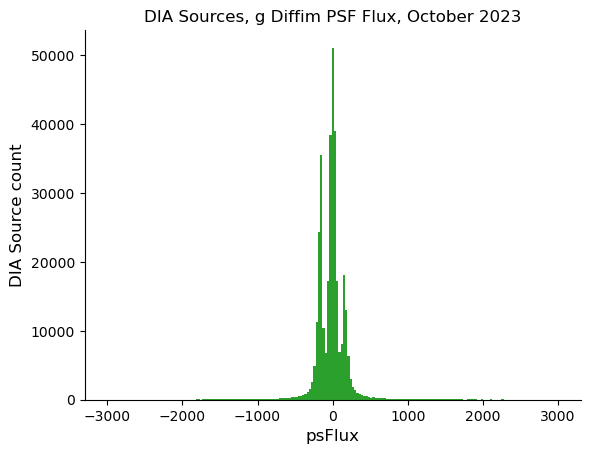

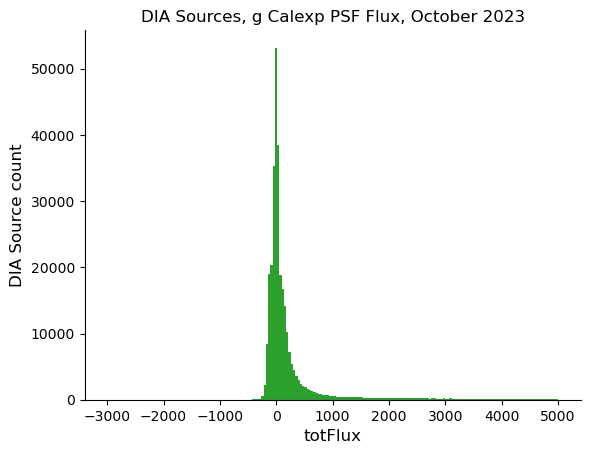

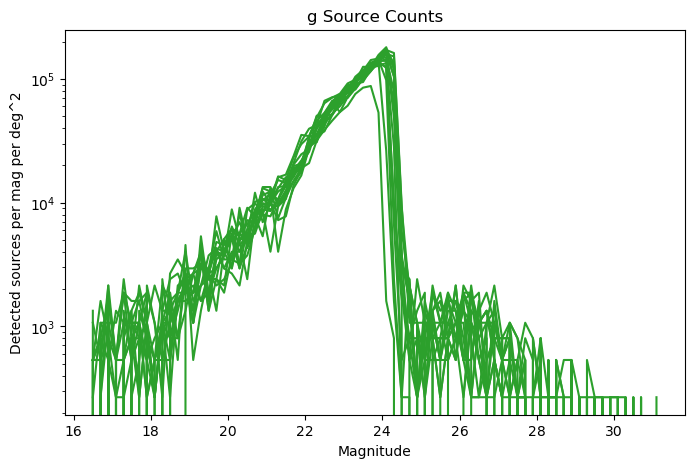

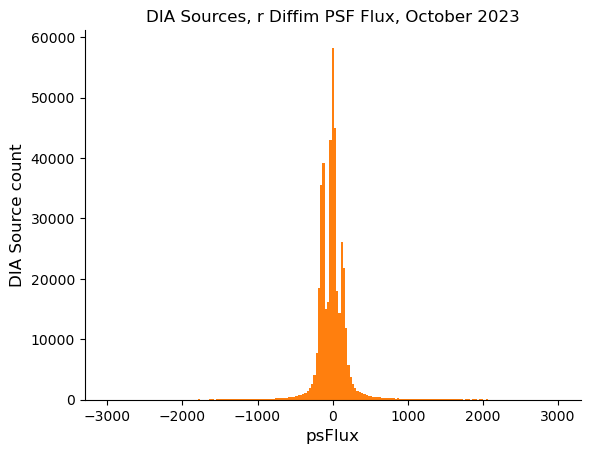

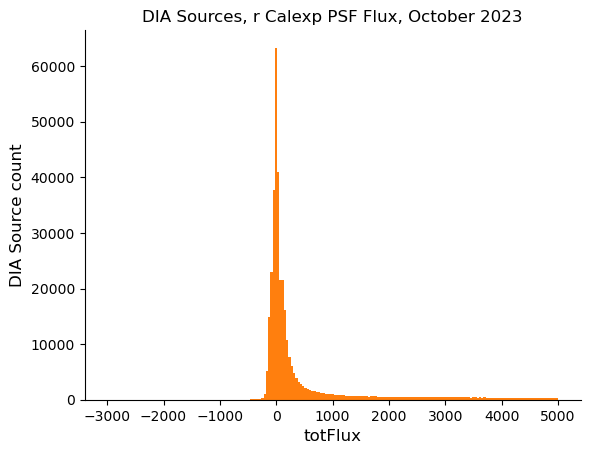

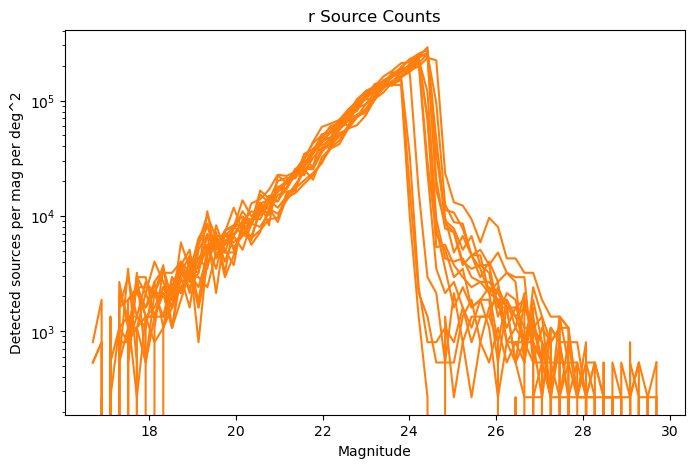

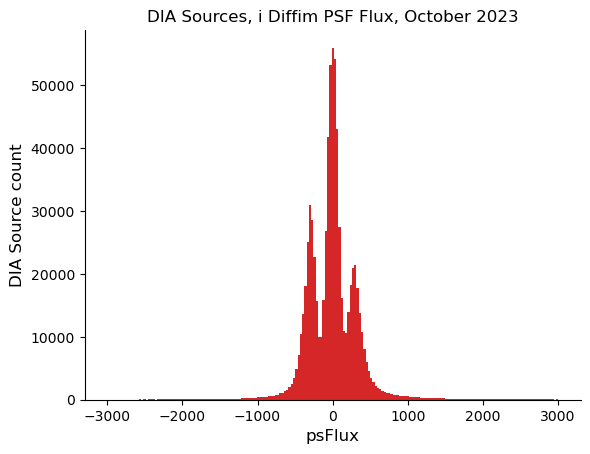

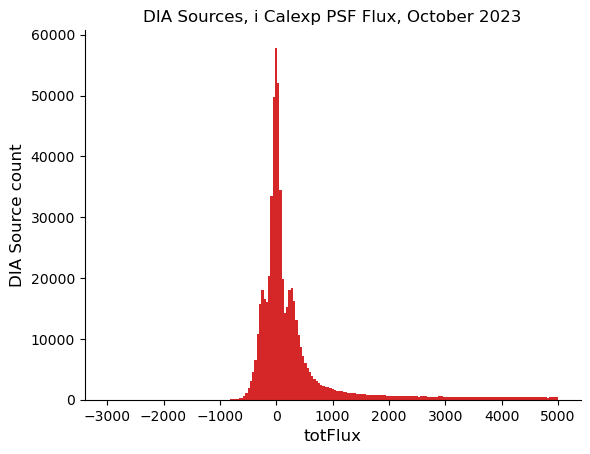

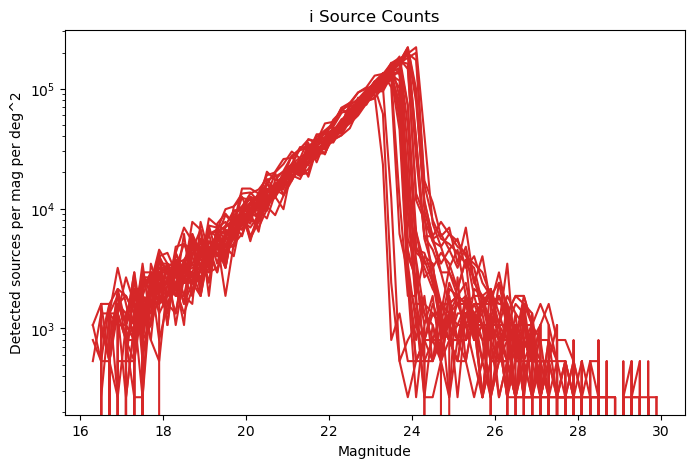

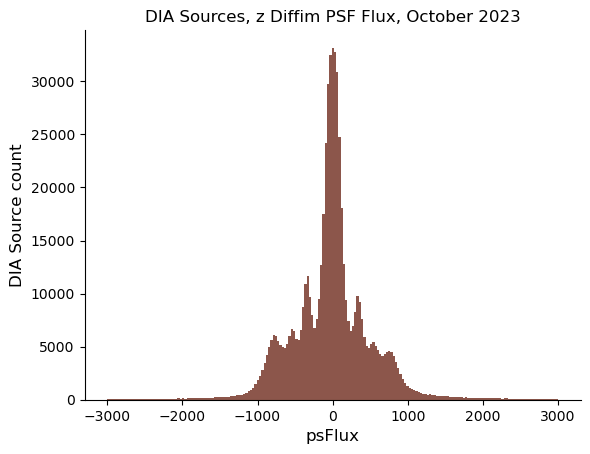

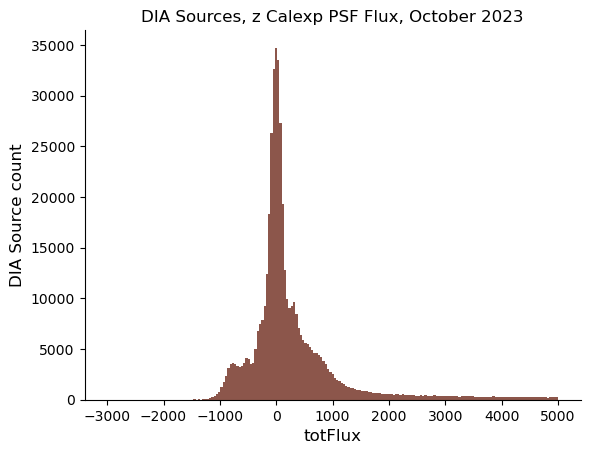

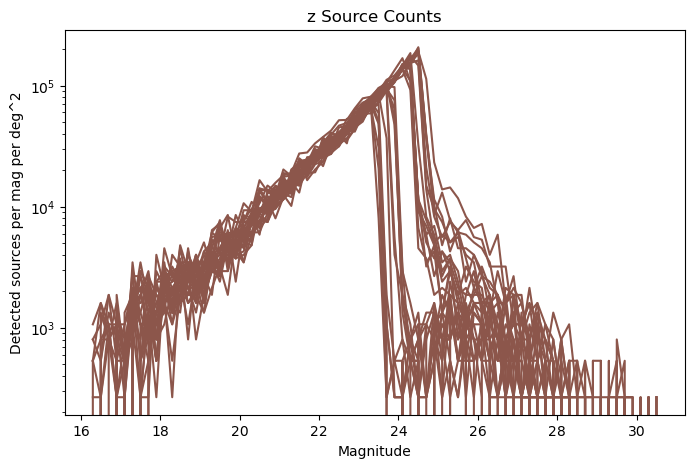

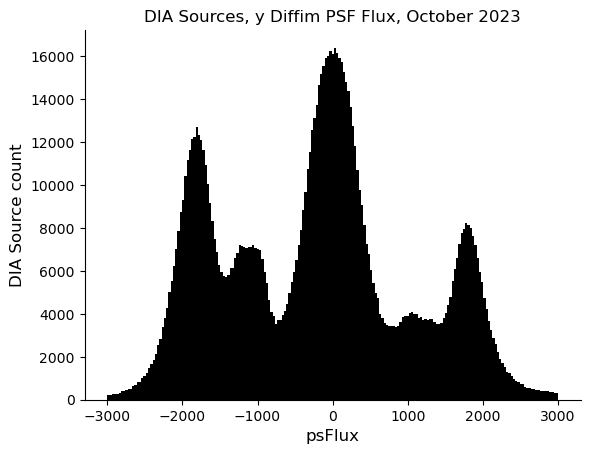

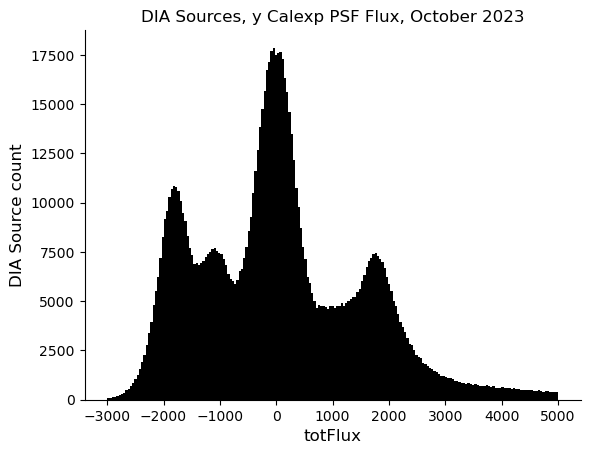

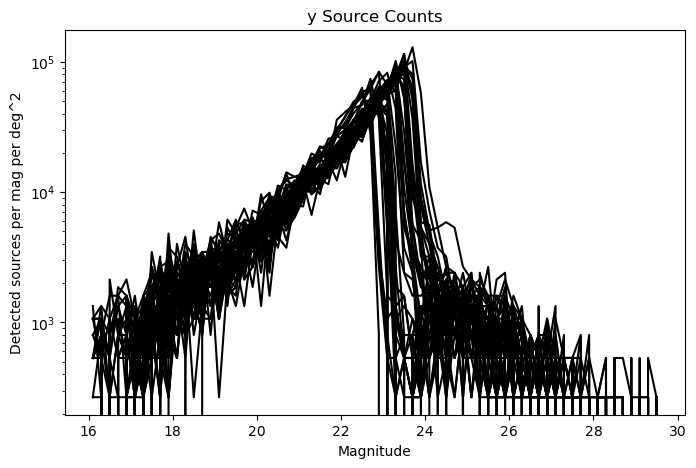

In [17]:
collection = collections

for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux, {month} {year}', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux, {month} {year}', color1=color, binmin=-3e3, binmax=5e3)
    plac.source_magnitude_histogram(repo, goodSrc, band, 'HSC', collection)

## 3. <a id="section_3">Comparison to previous processing run</a>

Again, where did the `g` band data come from?? Plots look similar for the other bands, though there are more good sources in the July run. Good DIA Objects/Sources by band histograms show marked increase in good objects and sources. The DIA Objects/Sources good vs. all histograms also show that the main increase is in the good objects/sources. While there was an increase in all DIA objects and sources, it wasn't a significant jump.

The numbers confirm this:
- The number of objects increased by 191043, and good objects increased by 440970.
- The number of sources increased by 389322, and good sources increased by 1312553.

Flags (although our plotting may need updated due to changes to some flags) show a major decrease almost across the board. Some noteable flag differences:
- `slot_Shape_flag_no_pixels` decreased by 2683043
- `base_PixelFlags_flag_cr` decreased by 2226206
- `base_PixelFlags_flag_crCenter` decreased by 1554218
- `base_PixelFlags_flag_interpolated` decreased by 1368588
- `base_PixelFlags_flag_interpolatedCenter` decreased by 1225142


### Visual

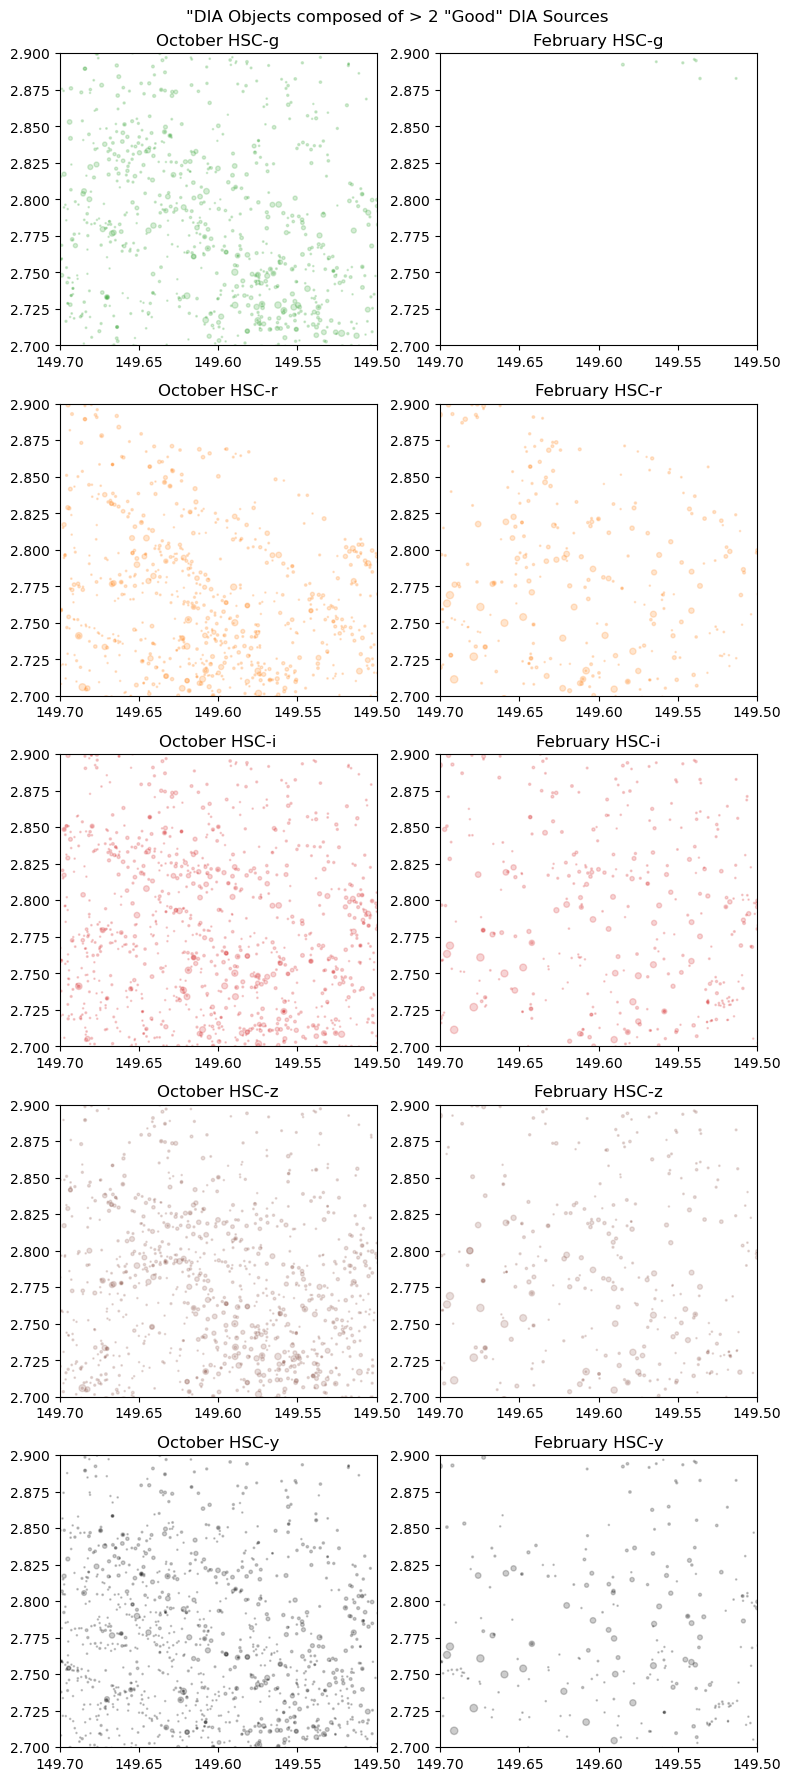

In [18]:
nSrc = 2
xlim = [149.7, 149.5]
ylim = [2.7, 2.9]
compare2 = compareByBand(goodObj, goodObj_old, nSrc = nSrc, alpha = 0.2, xlim = xlim, ylim = ylim,
                         title = f'"DIA Objects composed of > {nSrc} "Good" DIA Sources')

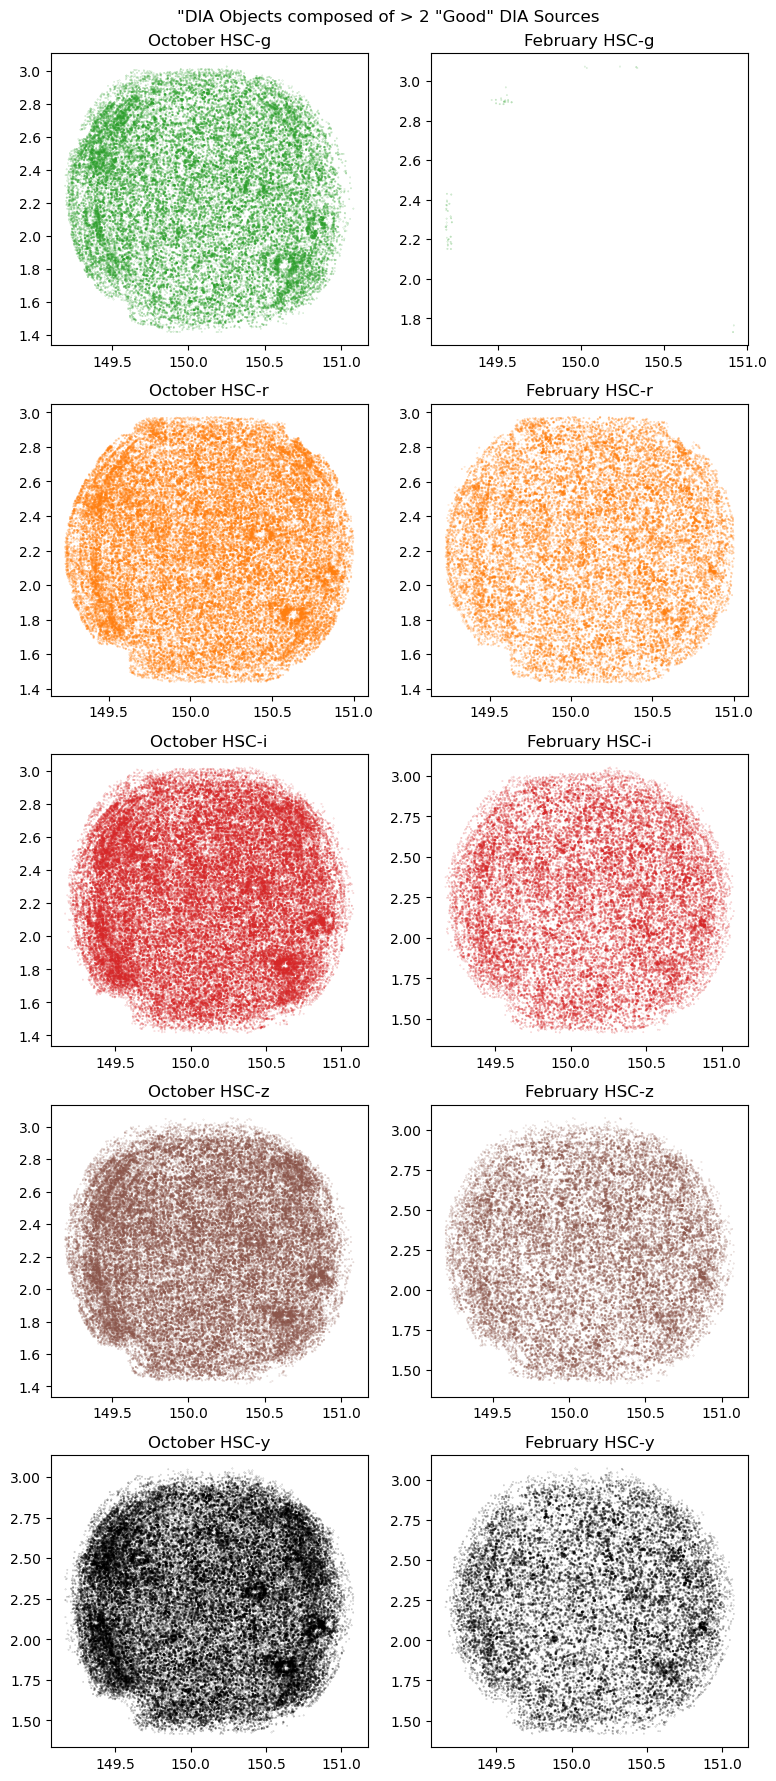

In [19]:
nSrc = 2
compare2 = compareByBand(goodObj, goodObj_old, nSrc = nSrc, alpha = 0.4, cutoff = 0,
                         title = f'"DIA Objects composed of > {nSrc} "Good" DIA Sources')

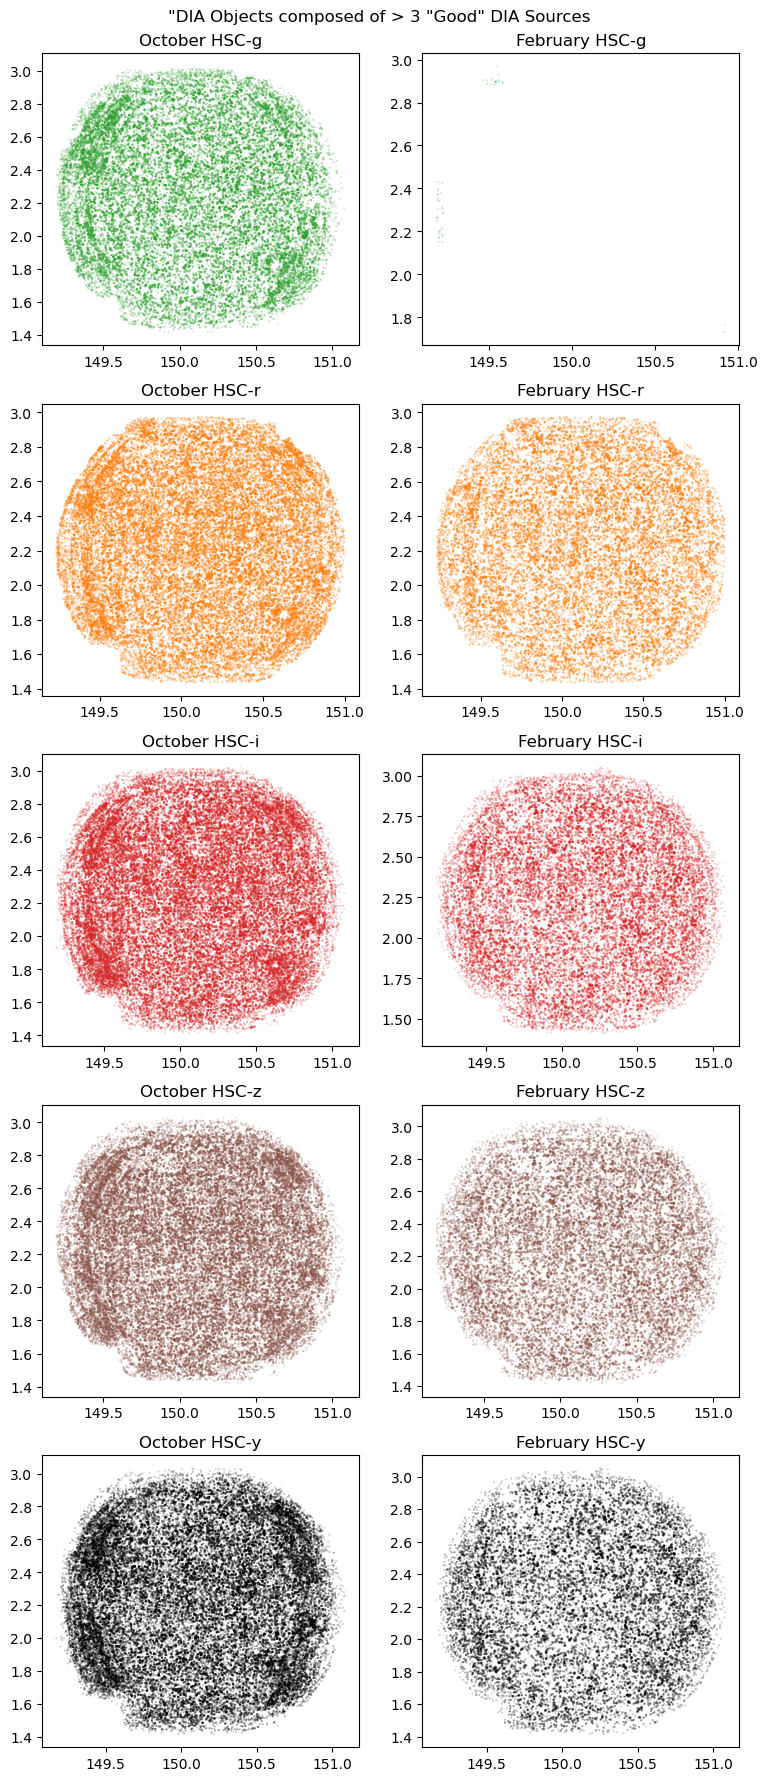

In [20]:
nSrc = 3
compare3 = compareByBand(goodObj, goodObj_old, nSrc = nSrc, alpha = 0.4, cutoff = 3,
                         title = f'"DIA Objects composed of > {nSrc} "Good" DIA Sources')

Text(0.5, 1.0, 'DIA Object and DIA Source counts (with fakes)')

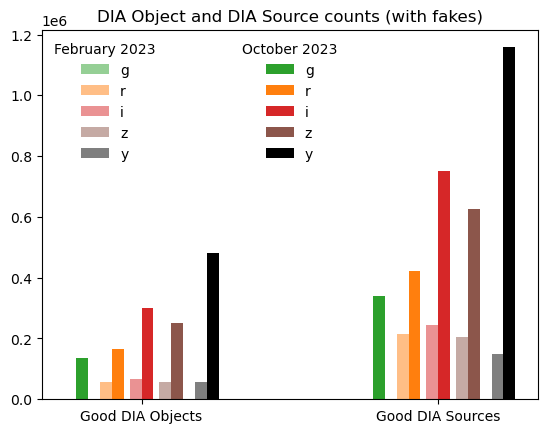

In [21]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Objects', 'Good DIA Sources']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
goodObjG_old = goodObj_old.loc[goodObj_old['gPSFluxMean'] > 0]
goodObjR_old = goodObj_old.loc[goodObj_old['rPSFluxMean'] > 0]
goodObjI_old = goodObj_old.loc[goodObj_old['iPSFluxMean'] > 0]
goodObjZ_old = goodObj_old.loc[goodObj_old['zPSFluxMean'] > 0]
goodObjY_old = goodObj_old.loc[goodObj_old['yPSFluxMean'] > 0]

goodSrcG_old = goodSrc_old.loc[goodSrc_old['filterName'] == 'g']
goodSrcR_old = goodSrc_old.loc[goodSrc_old['filterName'] == 'r']
goodSrcI_old = goodSrc_old.loc[goodSrc_old['filterName'] == 'i']
goodSrcZ_old = goodSrc_old.loc[goodSrc_old['filterName'] == 'z']
goodSrcY_old = goodSrc_old.loc[goodSrc_old['filterName'] == 'y']

g_old = ax.bar(xbar - (6/5) * width, [len(goodObjG_old), len(goodSrcG_old)], width/5, label='g', color='C2', alpha=0.5)
r_old = ax.bar(xbar - (3/5) * width, [len(goodObjR_old), len(goodSrcR_old)], width/5, label='r', color='C1', alpha=0.5)
i_old = ax.bar(xbar - (1/10) * width, [len(goodObjI_old), len(goodSrcI_old)], width/5, label='i', color='C3', alpha=0.5)
z_old = ax.bar(xbar + (2/5) * width, [len(goodObjZ_old), len(goodSrcZ_old)], width/5, label='z', color='C5', alpha=0.5)
y_old = ax.bar(xbar + width, [len(goodObjY_old), len(goodSrcY_old)], width/5, label='y', color='k', alpha=0.5)

# Current 
goodObjG = goodObj.loc[goodObj['gPSFluxMean'] > 0]
goodObjR = goodObj.loc[goodObj['rPSFluxMean'] > 0]
goodObjI = goodObj.loc[goodObj['iPSFluxMean'] > 0]
goodObjZ = goodObj.loc[goodObj['zPSFluxMean'] > 0]
goodObjY = goodObj.loc[goodObj['yPSFluxMean'] > 0]

goodSrcG = goodSrc.loc[goodSrc['filterName'] == 'g']
goodSrcR = goodSrc.loc[goodSrc['filterName'] == 'r']
goodSrcI = goodSrc.loc[goodSrc['filterName'] == 'i']
goodSrcZ = goodSrc.loc[goodSrc['filterName'] == 'z']
goodSrcY = goodSrc.loc[goodSrc['filterName'] == 'y']

g = ax.bar(xbar - width, [len(goodObjG), len(goodSrcG)], width/5, label='g', color='C2')
r = ax.bar(xbar - (2/5) * width, [len(goodObjR), len(goodSrcR)], width/5, label='r', color='C1')
i = ax.bar(xbar + (1/10) * width, [len(goodObjI), len(goodSrcI)], width/5, label='i', color='C3')
z = ax.bar(xbar + (3/5) * width, [len(goodObjZ), len(goodSrcZ)], width/5, label='z', color='C5')
y = ax.bar(xbar + (6/5) * width, [len(goodObjY), len(goodSrcY)], width/5, label='y', color='k')

ax.set_xticks([0, 1])
labels = ax.set_xticklabels(barLabels)
previous_legend = plt.legend(handles=[g_old, r_old, i_old, z_old,  y_old], loc='upper left', frameon=False, title=label1)
ax = plt.gca().add_artist(previous_legend)
current_legend = plt.legend(handles=[g, r, i, z,  y], loc='upper center', frameon=False, title=label2)
plt.title(f'DIA Object and DIA Source counts ({fakeStatus})')

Text(0.5, 1.0, 'Comparing DIA Object and Source counts (with fakes)')

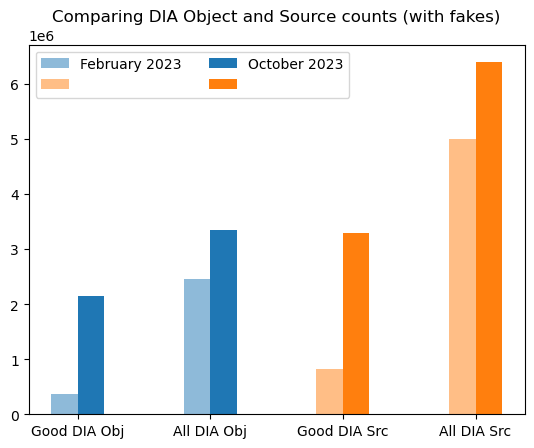

In [22]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
ax.bar(xbar - width/2, [len(goodObj_old), len(objTable_old)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc_old), len(srcTable_old)],
       width, label=' ', color='C1', alpha=0.5)

# Current Run
ax.bar(xbar + width/2, [len(goodObj), len(objTable)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc), len(srcTable)],
       width, label=' ', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title(f'Comparing DIA Object and Source counts ({fakeStatus})')

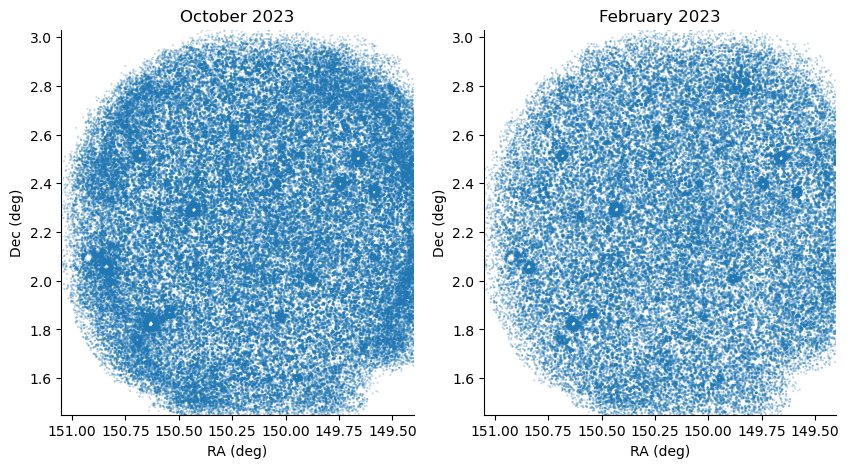

In [23]:
cutoff = 3
compareAll(goodObj, goodObj_old, cutoff = cutoff,
           title = f'DIA Objects composed of > {cutoff} "Good" DIA Sources ({fakeStatus})')

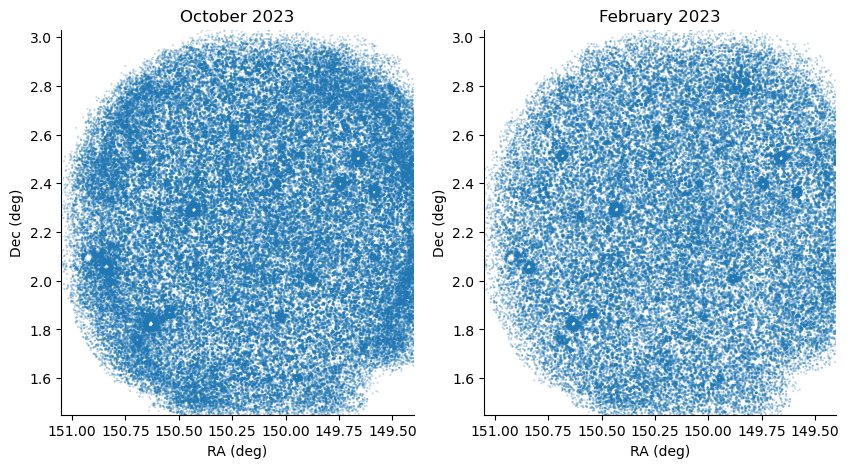

In [24]:
cutoff = 3
compareAll(goodObj, goodObj_old, cutoff = cutoff,
           title = f'DIA Objects composed of > {cutoff} "Good" DIA Sources ({fakeStatus})')

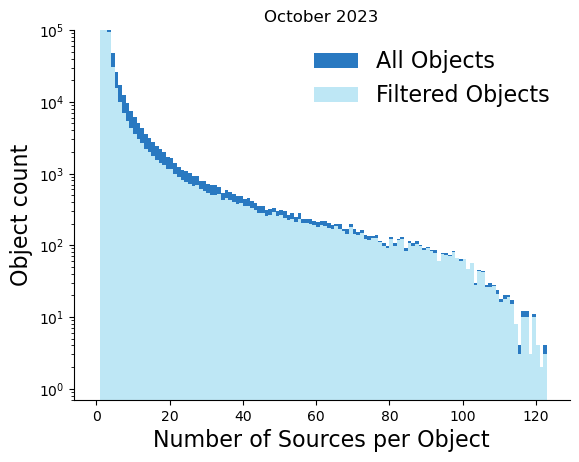

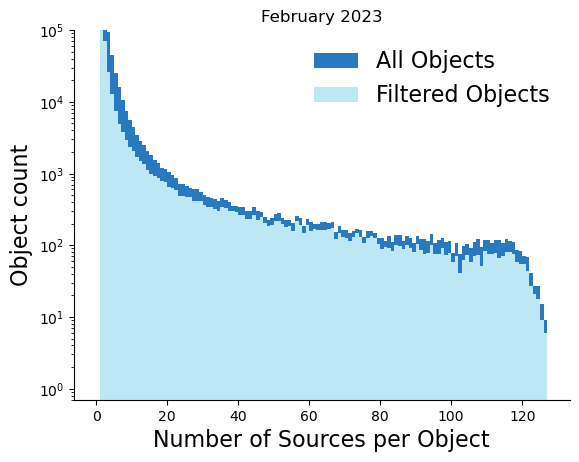

In [25]:
plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year}');
plac.plotDiaObjectHistogram(objTable_old, goodObj_old, title=f'{month_old} {year_old}');

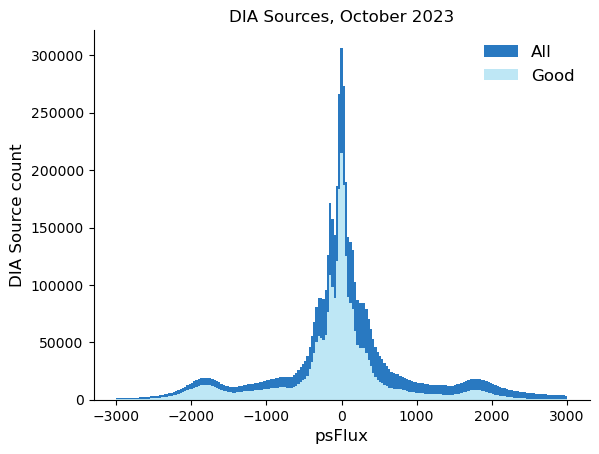

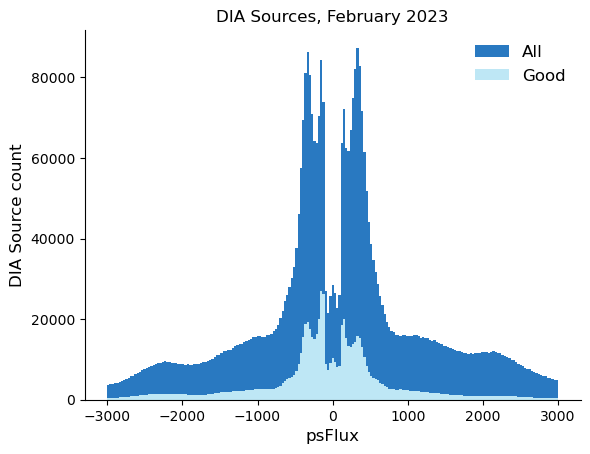

In [26]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}')

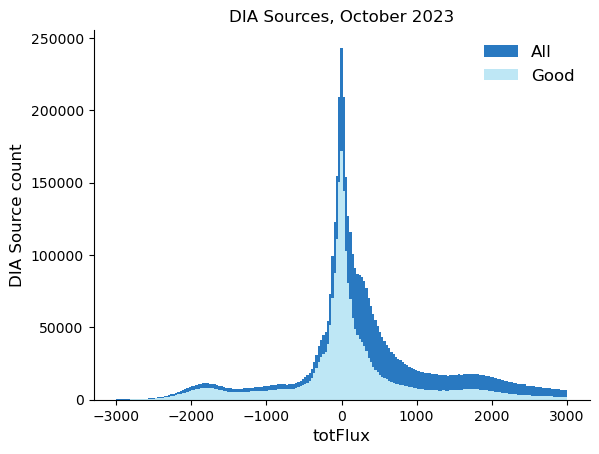

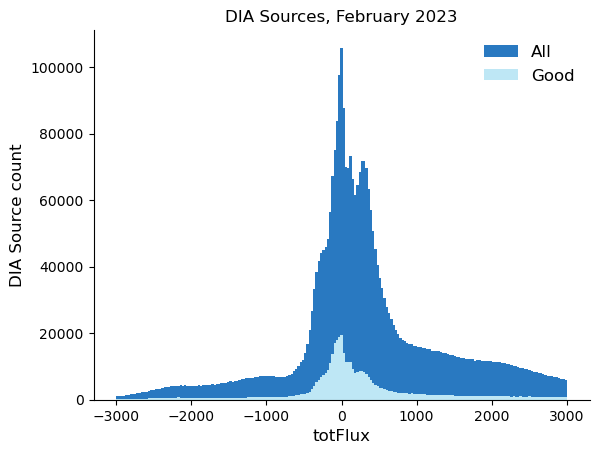

In [27]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}')

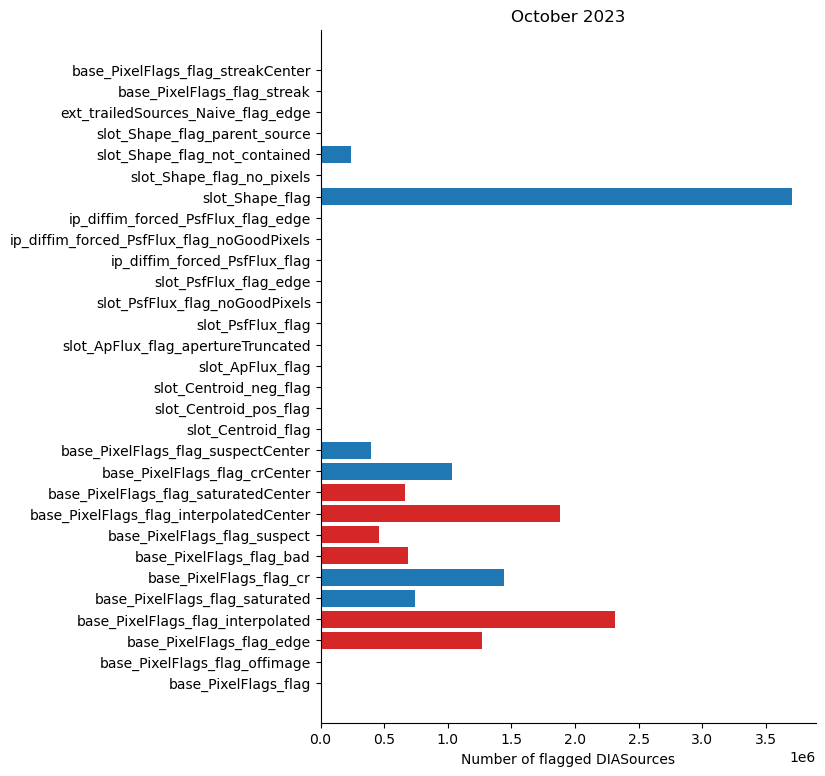

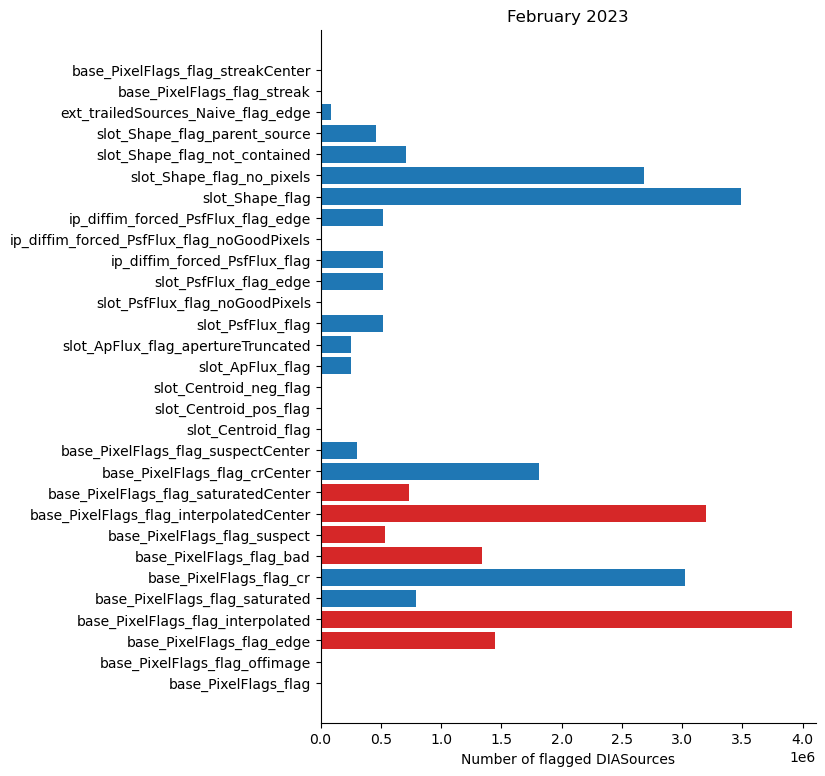

In [28]:
plac.plotFlagHist(srcTable, title=f'{month} {year}', badFlagList=badFlagList)
plac.plotFlagHist(srcTable_old, title=f'{month_old} {year_old}', badFlagList=badFlagList)

### By the numbers

In [29]:
nGoodObj = len(goodObj)
nGoodObj_old = len(goodObj_old)

print(f"{month} {year}, Number of good objects: ",nGoodObj)
print(f"{month_old} {year_old}, Number of good objects: ",nGoodObj_old)

print("Diff: ", nGoodObj-nGoodObj_old)

October 2023, Number of good objects:  2145507
February 2023, Number of good objects:  363523
Diff:  1781984


In [30]:
nObj = len(objTable)
nObj_old = len(objTable_old)

print(f"{month} {year}, Number of objects: ",nObj)
print(f"{month_old} {year_old}, Number of objects: ",nObj_old)

print("Diff: ", nObj-nObj_old)

October 2023, Number of objects:  3352118
February 2023, Number of objects:  2451020
Diff:  901098


In [31]:
nGoodSrc = len(goodSrc)
nGoodSrc_old = len(goodSrc_old)

print(f"{month} {year}, Number of good sources: ",nGoodSrc)
print(f"{month_old} {year_old}, Number of good sources: ",nGoodSrc_old)

print("Diff: ", nGoodSrc-nGoodSrc_old)

October 2023, Number of good sources:  3295613
February 2023, Number of good sources:  814855
Diff:  2480758


In [32]:
nSrc = len(srcTable)
nSrc_old = len(srcTable_old)

print(f"{month} {year}, Number of sources: ",nSrc)
print(f"{month_old} {year_old}, Number of sources: ",nSrc_old)

print("Diff: ", nSrc-nSrc_old)

October 2023, Number of sources:  6395278
February 2023, Number of sources:  5002525
Diff:  1392753


In [33]:
flagSum = flagTable.sum()
flagSum_old = flagTable_old.sum()

print(f"Difference between {month} {year} run and {month_old} {year_old} run, ordered:")
flagSum.subtract(flagSum_old).sort_values()

Difference between October 2023 run and February 2023 run, ordered:


slot_Shape_flag_no_pixels                    -2683043
base_PixelFlags_flag_interpolated            -1599967
base_PixelFlags_flag_cr                      -1583691
base_PixelFlags_flag_interpolatedCenter      -1312904
base_PixelFlags_flag_crCenter                 -775315
base_PixelFlags_flag_bad                      -652861
slot_PsfFlux_flag                             -507555
ip_diffim_forced_PsfFlux_flag                 -506981
ip_diffim_forced_PsfFlux_flag_edge            -506903
slot_PsfFlux_flag_edge                        -506903
slot_Shape_flag_not_contained                 -471021
slot_Shape_flag_parent_source                 -457341
slot_ApFlux_flag_apertureTruncated            -250392
slot_ApFlux_flag                              -247445
base_PixelFlags_flag_edge                     -177955
ext_trailedSources_Naive_flag_edge             -90264
base_PixelFlags_flag_suspect                   -80970
base_PixelFlags_flag_saturatedCenter           -74318
base_PixelFlags_flag_saturat

## 4. <a id="section_4">Separating the fake sources from the real sources</a>

There was a significant increase in matched fake and fake sources, and I'm not sure if it can all be explained by the addition of `g` band data.

Additionally, there are more visits included in the July run than the February run. And in all visits, there are more matched injected fakes.

Numbers:
- The number of matched fake sources increased by 214564.
- The number of non-fake sources increased by 174758.

July, visits 11700 through 11710:
- visit 11700: 30793 DIA Sources, 4425 matched injected fakes
- visit 11702: 23986 DIA Sources, 4959 matched injected fakes
- visit 11704: 25267 DIA Sources, 4535 matched injected fakes
- visit 11706: 30858 DIA Sources, 4591 matched injected fakes
- visit 11708: 31380 DIA Sources, 4582 matched injected fakes
- visit 11710: 31648 DIA Sources, 4882 matched injected fakes

February, visits 11700 through 11710:
- visit 11702: 113 DIA Sources, 25 matched injected fakes
- visit 11704: 140 DIA Sources, 31 matched injected fakes
- visit 11710: 92 DIA Sources, 28 matched injected fakes

### Setup

In [17]:
!eups list -s | grep analysis_tools

analysis_tools        LOCAL:/sdf/data/rubin/u/elhoward/repos/analysis_tools 	setup


In [21]:
tractList = [9813]

In [45]:
allInjectedFakes = butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=9813, storageClass='ArrowAstropy')
allInjectedFakes['ra'] = (allInjectedFakes['ra']*u.radian).to(u.deg)
allInjectedFakes['dec']= (allInjectedFakes['dec']*u.radian).to(u.deg)

In [31]:
allInjectedFakes_old = butler.get('fakes_fakeSourceCat', collections=collections_old,
                 instrument=instrument, skymap=skymap, tract=9813, storageClass='ArrowAstropy')
allInjectedFakes_old

<Table length=8863>
       fakeId                dec          ... bulge_pa sourceType
       uint64              float64        ... float64     str4   
-------------------- -------------------- ... -------- ----------
11339921294723747657  0.03041078030245489 ...      1.0       star
13508594034953153567  0.03481500653936828 ...      1.0       star
10061695001111823235  0.04208097654729439 ...      1.0       star
10160649729451212320  0.04033357262773534 ...      1.0       star
11501236932388067930  0.03389624199594218 ...      1.0       star
11510766126760399962  0.04109441969797184 ...      1.0       star
 9877052622918049119 0.035905862323254455 ...      1.0       star
13675661663167404630  0.04931014801953099 ...      1.0       star
13235321884845461104  0.05676892258306115 ...      1.0       star
 9448200194977727782 0.033029577617777355 ...      1.0       star
                 ...                  ... ...      ...        ...
13236740964016448957  0.05044638038940136 ...      1.0       star
10472951642481650457  0.02920999053075866 ...      1.0       star
 9573157635917324832   0.0594460574569587 ...      1.0       star
12385032758984513570  0.04421273472949769 ...      1.0       star
10498898626043326726   0.0554492637727161 ...      1.0       star
12980162557453887505  0.04371680593653952 ...      1.0       star
12557850712695415754 0.055643921940541755 ...      1.0       star
10135486571415311965  0.04044683886734484 ...      1.0       star
10909706008494998138 0.036272015930185704 ...      1.0       star
10991106580878472079 0.021854629841985065 ...      1.0       star

In [27]:
diaSource = butler.get('fakes_goodSeeingDiff_diaSrcTable', collections=collections,
                 instrument=instrument, detector=62, visit=352, skymap=skymap, tract=9813, storageClass='ArrowAstropy')
diaSource

<Table length=828>
  diaSourceId   ccdVisitId band ...        ixyPSF             reliability     
     int64        int64    str1 ...       float64               float64       
--------------- ---------- ---- ... -------------------- ---------------------
151315992806244      70462    y ...  0.01932091306862857 0.0004212756175547838
151315992806245      70462    y ...  0.01947235201273691 0.0004212756175547838
151315992806246      70462    y ...  0.01941621565743818 0.0004212756175547838
151315992806247      70462    y ...  0.01952535578361625 0.0004212756175547838
151315992806248      70462    y ... 0.019369176454294892 0.0004212756175547838
151315992806249      70462    y ... 0.019404901388668842 0.0004212756175547838
151315992806250      70462    y ...  0.01950917745013962 0.0004212756175547838
151315992806251      70462    y ...  0.01939420439806395 0.0004212756175547838
151315992806252      70462    y ... 0.019506017069043504 0.0004212756175547838
151315992806253      70462    y ... 0.019521157521182723 0.0004212756175547838
            ...        ...  ... ...                  ...                   ...
151315992807062      70462    y ... 0.019936715549170998   0.02900346927344799
151315992807063      70462    y ...  0.02084867260231926    0.5062891244888306
151315992807064      70462    y ...  0.02007264738650173 0.0004906945978291333
151315992807065      70462    y ... 0.020645647873728058     0.127017080783844
151315992807066      70462    y ... 0.019772584240748087 0.0033686403185129166
151315992807067      70462    y ... 0.020707980978909617 0.0014053576160222292
151315992807068      70462    y ... 0.020513985390537667   0.17498888075351715
151315992807069      70462    y ... 0.019881133041437002 0.0006553408456966281
151315992807070      70462    y ... 0.020935999753099906    0.0165548138320446
151315992807071      70462    y ... 0.020007164510985085 0.0004212756175547838

In [32]:
diaSource_old = butler.get('fakes_goodSeeingDiff_diaSrcTable', collections=collections_old,
                 instrument=instrument, detector=62, visit=352, skymap=skymap, tract=9813, storageClass='ArrowAstropy')
diaSource_old

<Table length=391>
  diaSourceId   ccdVisitId filterName ...        ixyPSF        __index_level_0__
     int64        int64       str1    ...       float64              int64      
--------------- ---------- ---------- ... -------------------- -----------------
151315992805839      70462          y ... 0.019227276088071347                 0
151315992805840      70462          y ... 0.019115428990759444                 1
151315992805841      70462          y ... 0.019139886902182858                 2
151315992805842      70462          y ...  0.01912568037169946                 3
151315992805843      70462          y ... 0.019133328217869366                 4
151315992805844      70462          y ... 0.019142824691289362                 5
151315992805845      70462          y ... 0.019158645703115183                 6
151315992805846      70462          y ...  0.01914110243969884                 7
151315992805847      70462          y ... 0.019150380262739027                 8
151315992805848      70462          y ...  0.01918772012754003                 9
            ...        ...        ... ...                  ...               ...
151315992806220      70462          y ...  0.02033417578823939               381
151315992806221      70462          y ...  0.02049729741595499               382
151315992806222      70462          y ... 0.020526114128006888               383
151315992806223      70462          y ...   0.0204695350848459               384
151315992806224      70462          y ... 0.020403625324964685               385
151315992806225      70462          y ... 0.020434752766215397               386
151315992806226      70462          y ...  0.02042188318004979               387
151315992806227      70462          y ... 0.020587209010281278               388
151315992806228      70462          y ...   0.0204825223900885               389
151315992806229      70462          y ... 0.020615638248058146               390

In [37]:
from lsst.analysis.tools.tasks.catalogMatch import CatalogMatchTask

In [38]:
matched = CatalogMatchTask()
matched.run(catalog=diaSource, loadedRefCat=allInjectedFakes)

(2.343998019405287, 2.4363404295626214)

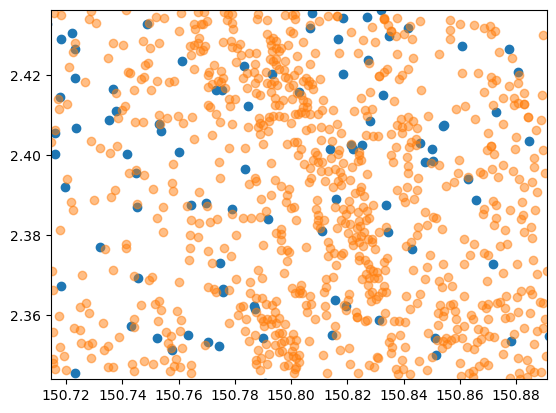

In [51]:
plt.scatter(allInjectedFakes['ra'], allInjectedFakes['dec'])
plt.scatter(diaSource['ra'], diaSource['dec'], alpha=0.5)
plt.xlim(diaSource['ra'].min(), diaSource['ra'].max())
plt.ylim(diaSource['dec'].min(), diaSource['dec'].max())

In [ ]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collections,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')

In [18]:
dfs = [butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes = pd.concat(dfs, ignore_index=True)

In [24]:
collections

'u/elhoward/DM-37699/HSC-precon-rb'

In [36]:
dfs_old = [butler.get('fakes_fakeSourceCat', collections=collections_old,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes_old = pd.concat(dfs_old, ignore_index=True)

In [24]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collections,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources = collectMatchedDiaSources(fakesMatchDiaSrc)

No real sources detected in fakes_goodSeeingDiff_matchDiaSrc@{instrument: 'HSC', detector: 101, visit: 30502, band: 'i', physical_filter: 'HSC-I'} [sc=DataFrame] (run=u/elhoward/DM-37699/HSC-precon-rb/20231026T023354Z id=43bebaeb-9025-49db-b76f-1ee3b67d321e)
No real sources detected in fakes_goodSeeingDiff_matchDiaSrc@{instrument: 'HSC', detector: 78, visit: 11706, band: 'g', physical_filter: 'HSC-G'} [sc=DataFrame] (run=u/elhoward/DM-37699/HSC-precon-rb/20231026T023354Z id=bdbd3f65-6c8e-49c8-9dbd-6ddaf677b619)
No real sources detected in fakes_goodSeeingDiff_matchDiaSrc@{instrument: 'HSC', detector: 81, visit: 22642, band: 'y', physical_filter: 'HSC-Y'} [sc=DataFrame] (run=u/elhoward/DM-37699/HSC-precon-rb/20231026T023354Z id=df858ce0-3f3b-47ef-a803-cf0c576446bf)
No real sources detected in fakes_goodSeeingDiff_matchDiaSrc@{instrument: 'HSC', detector: 4, visit: 22644, band: 'y', physical_filter: 'HSC-Y'} [sc=DataFrame] (run=u/elhoward/DM-37699/HSC-precon-rb/20231026T023354Z id=ed52f4


KeyboardInterrupt



In [23]:
fakesMatchDiaSrc_old = butler.registry.queryDatasets(collections=collections_old,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources_old = collectMatchedDiaSources(fakesMatchDiaSrc_old)

KeyboardInterrupt: 

In [20]:
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
dataId = packer.unpack(matchedDiaSources.ccdVisitId)
matchedDiaSources['visit'] = dataId['visit']
matchedDiaSources['detector'] = dataId['detector']

In [ ]:
dataId_old = packer.unpack(matchedDiaSources_old.ccdVisitId)
matchedDiaSources_old['visit'] = dataId_old['visit']
matchedDiaSources_old['detector'] = dataId_old['detector']

### Visual

Text(0.5, 1.0, 'DIA Objects, Fakes, and Matched DIA Sources, October 2023')

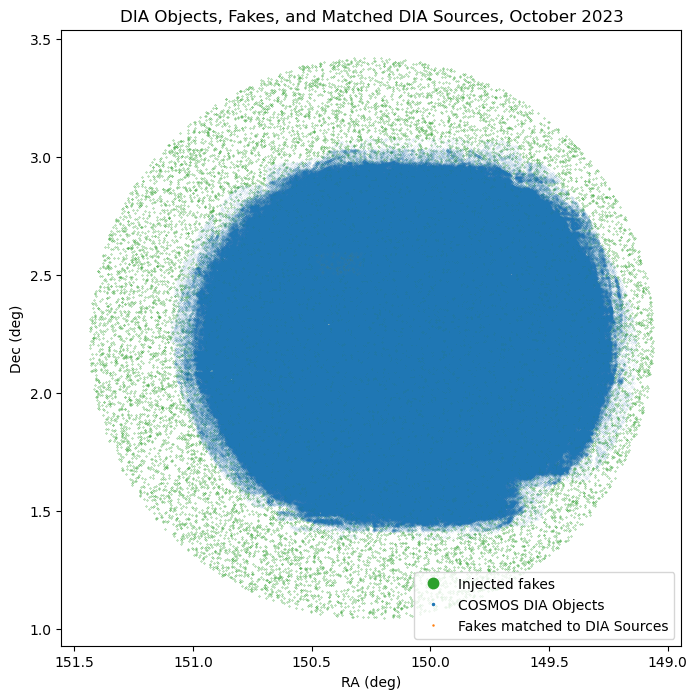

In [21]:
plt.figure(figsize=(8,8))
plt.plot(allInjectedFakes.ra*u.rad.to(u.deg), allInjectedFakes.dec*u.rad.to(u.deg),
         ls='None', marker='.', ms=0.5, label="Injected fakes", color='C2')
plt.plot(goodObj.ra, goodObj.decl, ls='None', marker='.', ms=0.1, label="COSMOS DIA Objects", color='C0')
plt.plot(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), ls='None', marker='.',
         ms=0.05, label="Fakes matched to DIA Sources", color='C1')
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(markerscale=30)
plt.title(f'DIA Objects, Fakes, and Matched DIA Sources, {month} {year}')

Text(0.5, 1.0, 'Stacked Visits, October 2023')

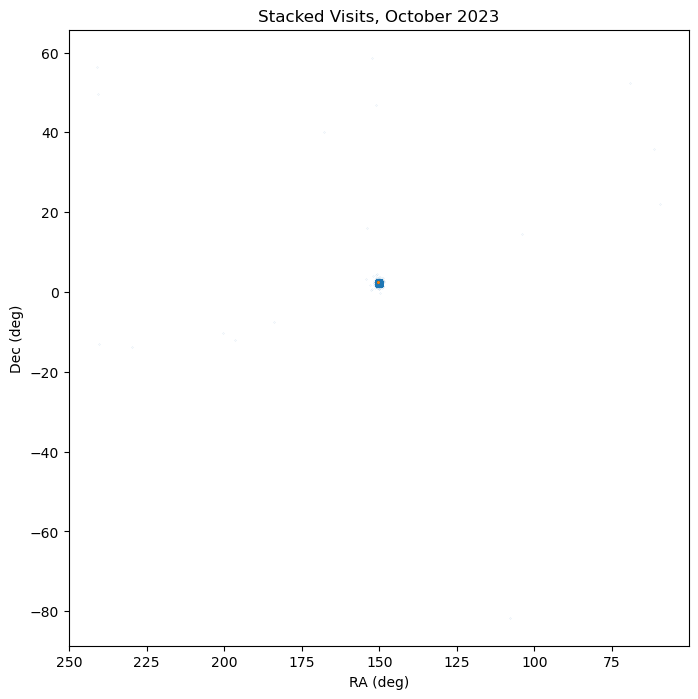

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(srcTable['ra'], srcTable['decl'],c='C0', s=0.01, alpha=0.5, label="COSMOS DIA Objects")
plt.scatter(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), c='C1', s=0.05, alpha=0.5, label="Fakes matched to DIA Sources")
plt.gca().invert_xaxis()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title(f'Stacked Visits, {month} {year}')

In [ ]:
# Plot visit-by-visit: DIA Sources (blue) and inserted fakes (orange)

sourceTablePlot = srcTable

visits = np.unique(sourceTablePlot['visit'])
nVisits = len(visits)
if np.floor(np.sqrt(nVisits)) - np.sqrt(nVisits) == 0:
    squareGridSize = int(np.sqrt(nVisits))
else:
    squareGridSize = int(np.sqrt(nVisits)) + 1

fig = plt.figure(figsize=(9, 9))
for count, visit in enumerate(np.unique(sourceTablePlot['visit'].values)):
    band = sourceTablePlot.loc[(sourceTablePlot.visit == visit), 'filterName'].iloc[0]
    color = [colorList[0] if band==bandList[0] else 
             colorList[1] if band==bandList[1] else 
             colorList[2] if band==bandList[2] else 
             colorList[3] if band==bandList[3] else 
             colorList[4] if band==bandList[4] else 
             colorList[5]]
    idx = sourceTablePlot.visit == visit
    ax = fig.add_subplot(squareGridSize, squareGridSize, count + 1, aspect='equal')
    ax.scatter(sourceTablePlot.ra[idx], sourceTablePlot.decl[idx], c=color, marker='.', s=0.005, alpha=0.3)
    
    fakeSources = matchedDiaSources.loc[matchedDiaSources.visit == visit]
    ax.scatter(fakeSources.ra_x*u.rad.to(u.deg), fakeSources.dec*u.rad.to(u.deg),
               c='0.75', marker='.', s=0.02, alpha=0.3)
    
    ax.set_title(visit, size=8)
    ax.invert_xaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(f'visit {visit}: {len(sourceTablePlot.loc[sourceTablePlot.visit == visit])} DIA Sources, {len(fakeSources)} matched injected fakes')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0)

### By the numbers

In [ ]:
nFakesMatched = len(matchedDiaSources)
nFakesMatched_old = len(matchedDiaSources_old)

print(f"{month} {year}, Number of matched fake DIA sources:", nFakesMatched)
print(f"{month_old} {year_old}, Number of matched fake DIA sources:", nFakesMatched_old)

print("Diff: ", nFakesMatched-nFakesMatched_old)

In [ ]:
nFakesDiff = len(srcTable) - nFakesMatched
nFakesDiff_old = len(srcTable_old) - nFakesMatched_old

print(f"{month} {year}, Number of non-fake DIA Sources: ", nFakesDiff)
print(f"{month_old} {year_old}, Number of non-fake DIA Sources: ", nFakesDiff_old)

print("Diff: ", nFakesDiff-nFakesDiff_old)

## 5. <a id="section_5">Fakes completeness analysis</a>

Plots are consistent with previous run.

In [ ]:
completenessByBandPlot(matchedDiaSources, bandList, colorList,
                       flux_col_suffix='_mag', doRaDecCut=False)

## 6. <a id="section_6">Calexp and PSF analysis</a>

Plots are consistent with previous run. Accepted and rejected PSF sources are evenly distributed.

In [ ]:
visits = [29350]
detectors = [49]

In [ ]:
for collection in collectionsList:
    for visit in visits:
        for detector in detectors:
            print('Collection: ', collection,
                  ', Visit: ', visit,
                  ', Detector: ', detector)
            afwDisplay.setDefaultBackend('matplotlib') 

            calexp = butler.get('calexp', instrument='HSC',
                                visit=visit, detector=detector, collections=collection)
            fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))

            plt.sca(ax1)  # set the first axis as current
            display1 = afwDisplay.Display(frame=fig)
            display1.scale('asinh', -1, 30)
            display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')

            plt.sca(ax2)  # set the second axis as current
            display2 = afwDisplay.Display(frame=fig)
            display2.mtv(calexp.mask, f'{collection}\nMask\nVisit: {visit} Detector: {detector}')

            plt.sca(ax3) # set the third axis as current
            display3 = afwDisplay.Display(frame=fig)
            display3.scale('asinh', 'zscale')
            display3.mtv(calexp.variance, f'{collection}\nVariance\nVisit: {visit} Detector: {detector}')

            plt.tight_layout()
            plt.show()
            plt.close(fig)

In [ ]:
for visit in visits:
    for detector in detectors:
        print('Visit: ', visit, ', Detector: ', detector)
        afwDisplay.setDefaultBackend('matplotlib') 

        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))

        plt.sca(ax1)  # set the first axis as current
        calexp1 = butler.get('calexp', instrument=instrument,
                        visit=visit, detector=detector, collections=collections)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp1, f'{collections}\nVisit: {visit} Detector: {detector}')
        src1 = butler.get('src', instrument=instrument,
                          visit=visit, detector=detector, collections=collections)
        with display1.Buffering():
            for record in src1:
                display1.dot('o', record.getX(), record.getY(), size=20, ctype='orange')

        plt.sca(ax2)  # set the second axis as current
        calexp2 = butler.get('calexp', instrument=instrument,
                        visit=visit, detector=detector, collections=collections_old)
        display2 = afwDisplay.Display(frame=fig)
        display2.setMaskTransparency(80)
        display2.scale('asinh', -1, 30)
        display2.mtv(calexp2, f'{collections_old}\nVisit: {visit} Detector: {detector}')
        src2 = butler.get('src', instrument=instrument,
                          visit=visit, detector=detector, collections=collections_old)
        with display2.Buffering():
            for record in src2:
                display2.dot('o', record.getX(), record.getY(), size=20, ctype='orange')
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [ ]:
for collection in collectionsList:
    for visit in visits:
        for detector in detectors:
            print('Collection: ', collection,
                  ', Visit: ', calexp.visitInfo.getId(),
                  ', Detector: ', calexp.detector.getId())
            
            afwDisplay.setDefaultBackend('matplotlib') 
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))
            
            plt.sca(ax1)  # set the first axis as current
            calexp = butler.get('calexp', instrument=instrument,
                                visit=visit, detector=detector, collections=collection)
            display1 = afwDisplay.Display(frame=fig)
            display1.setMaskTransparency(80)
            display1.scale('asinh', -1, 30)
            display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')
            src = butler.get('src', instrument=instrument,
                             visit=visit, detector=detector, collections=collection)
            acceptedPsfSources = src[src['calib_psf_used']]
            rejectedPsfSources = src[src['calib_psf_candidate'] &
                                 (src['calib_psf_used'] == False)]
            print('Accepted PSF Sources (green): ', len(acceptedPsfSources),
                  ' Rejected PSF Sources (red): ', len(rejectedPsfSources))
            with display1.Buffering():
                for s in src[src['calib_psf_used']]:
                    display1.dot("x", s.getX(), s.getY(), size=10, ctype='red')
            with display1.Buffering():
                for s in rejectedPsfSources:
                    display1.dot("+", s.getX(), s.getY(), size=10, ctype='green')

            plt.sca(ax2)  # set the second axis as current
            psf = calexp.getPsf()
            position = psf.getAveragePosition()
            display2 = afwDisplay.Display(frame=fig)
            display2.mtv(psf.computeImage(position), f'{collection}\nPSF\nVisit: {visit} Detector: {detector}')
            
            plt.tight_layout()
            plt.show()
            plt.close(fig)

## 7. <a id="section_7">SNR distributions</a>

Aside from the addition of `g` band, SNR distribution is consistent with previous run. Still have some outliers.

In [ ]:
binwidth=100

plt.figure(figsize=(10,4))
plt.yscale('log')
for band, color in zip(bandList, colorList):
    data = srcTable.loc[srcTable.filterName==band, 'snr']
    snrHist = plt.hist(data, bins=range(0, int(max(data)) + binwidth, binwidth), color=color, alpha=0.5, label=band, histtype='step')
plt.legend()
plt.title(f'SNR distribution from DIA Source table (cropped), {month} {year}')
plt.xlabel('SNR of DIA Sources')
plt.gca().set_xlim(0, 10000)

In [ ]:
binwidth = 1000

plt.figure(figsize=(10,4))
plt.yscale('log')
for band, color in zip(bandList[1:3], colorList[1:3]):
    data = srcTable.loc[srcTable.filterName==band, 'snr']
    snrHist = plt.hist(data, bins=range(0, int(max(data)) + binwidth, binwidth), color=color, alpha=0.5, label=band, histtype='step')
plt.legend()
plt.title(f'SNR distribution from DIA Source table (extended, r and i bands), {month} {year}')
plt.xlabel('SNR of DIA Sources')

In [ ]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

In [ ]:
binwidth=100

plt.figure(figsize=(10,4))
plt.yscale('log')
for band, color in zip(bandList, colorList):
    data = srcTable.loc[srcTable.filterName==band, 'psFluxSNR']
    psFluxHist = plt.hist(data, bins=range(0, int(max(data)) + binwidth, binwidth), color=color, alpha=0.5, label=band, histtype='step')
plt.legend()
plt.title(f'Approximate SNR distribution for difference image fluxes, {month} {year}')
plt.xlabel('psFlux/psFluxErr')

In [ ]:
plt.figure(figsize=(10,4))
plt.yscale('log')
for band, color in zip(bandList, colorList):
    totFluxHist = plt.hist(srcTable.loc[srcTable.filterName==band, 'totFluxSNR'], bins=50, color=color, alpha=0.5, label=band, histtype='step')
plt.legend()
plt.title(f'Approximate SNR distribution for forced source photometry fluxes\n{month} {year}')
plt.xlabel('totFlux/totFluxErr')